<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/01_Tutorial_ResNet_VAE_Recon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check the results
* 01. Tutorial-ResNet-VAE
* Epoch5
* Reconstruct it 

In [1]:
# drive mount

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
%cd drive/My\ Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
! ls

/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
01.Tutorial-ResNet-VAE.ipynb	    README.md
01.Tutorial-ResNet-VAE-Recon.ipynb  ResNetVAE_cifar10.py
fig				    ResNetVAE_FACE.py
modules.py			    ResNetVAE_MNIST.py
plot_latent.ipynb		    ResNetVAE_reconstruction.ipynb
__pycache__			    results_Malimg


## 01. Import Library

In [8]:
%matplotlib inline
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import pickle
import numpy as np

from modules import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.models as modules
import torch.utils.data as data

from sklearn.model_selection import train_test_split

In [10]:
# define decoder

def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    return new_images

saved_model_path = './results_Malimg'

exp = 'Malimg'

# use same ResNet Encoder saved earlier!
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256
res_size = 224   # ResNet image size
dropout_p = 0.2  # dropout probability

epoch = 5  # hyper parameter
           # when you load?

use_cuda = torch.cuda.is_available()                  # check if GPU is available
device = torch.device("cuda" if use_cuda else "cpu")  # use CPU or GPU

# reload ResNetVAE model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.load_state_dict(torch.load(os.path.join(saved_model_path, 'model_epoch{}.pth'.format(epoch))))

print("ResNet VAE epoch {} model reloaded!".format(epoch))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



ResNet VAE epoch 5 model reloaded!


## Reconstruction

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


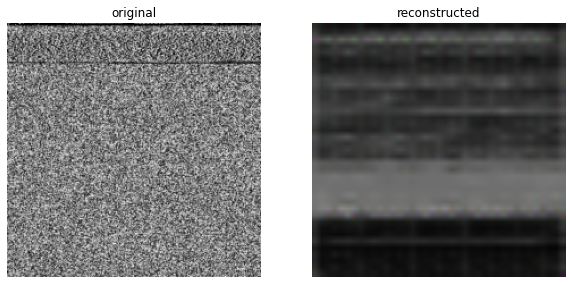

In [11]:
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
X_train = np.load(os.path.join(saved_model_path, 'X_{}_train_epoch{}.npy').format(exp, epoch))

ind = 1
zz = torch.from_numpy(z_train[ind]).view(1, -1)
X = np.transpose(X_train[ind], (1, 2, 0))

new_imgs = decoder(resnet_vae, device, zz)

fig = plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_imgs)
plt.title('reconstructed')
plt.axis('off')
plt.savefig("./reconstruction_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

## Generate new images from latent points

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


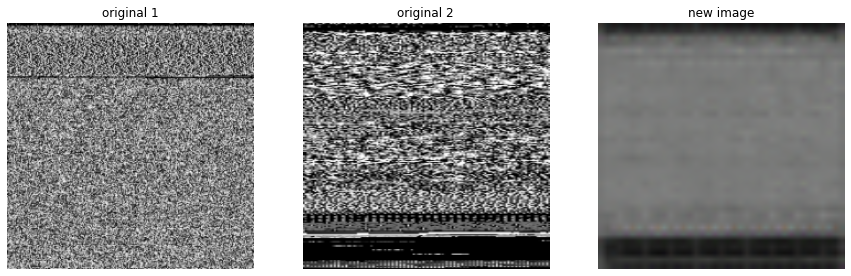

In [12]:
# choose two original images
sample1, sample2 = 0, 1
w = 0.4 # weight for fusing two images

X1 = np.transpose(X_train[-sample1], (1, 2, 0))
X2 = np.transpose(X_train[-sample2], (1, 2, 0))

# generate image using decoder
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
z = z_train[-sample1] * w + z_train[-sample2] * (1 - w)
new_imgs = decoder(resnet_vae, device, torch.from_numpy(z).view(1, -1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(X1)
plt.title('original 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X2)
plt.title('original 2')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(new_imgs)
plt.title('new image')
plt.axis('off')
plt.savefig("./generated_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()